In [178]:
import numpy as np 
import pandas as pd 
import h5py
import re
import uproot
import glob 
import copy 
import matplotlib.pyplot as plt
from tqdm import tqdm 
from utils import ParticleCode

# Load your custom style 
plt.style.use('./cfg/my_custom_plot.mplstyle')

# use these lines on top of your matplotlib script
import matplotlib.ticker
class MyLocator(matplotlib.ticker.AutoMinorLocator):
    def __init__(self, n=4):
        super().__init__(n=n)
matplotlib.ticker.AutoMinorLocator = MyLocator        
 
# Now use matplotlib as usual.       
import matplotlib.pyplot as plt
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True

In [179]:
# Geometry for MiniRun 5
anode_xs = np.array([-63.931, -3.069, 3.069, 63.931])
anode_ys = np.array([-19.8543, 103.8543])  # two ys
anode_zs = np.array([-64.3163, -2.6837, 2.6837, 64.3163])  # four zs

# hit coordinates are in cm
detector_center = (0, 0, 0)
anode_ys = anode_ys - 42

In [180]:
f_directory = "/global/cfs/cdirs/dune/www/data/2x2/simulation/productions/MiniRun5_1E19_RHC/MiniRun5_1E19_RHC.flow.beta2a/FLOW"
plot_dir = "./plots/"

# G4 Subprocess labels
HadronElastic = 111
HadronInelastic = 121
HadronCapture = 131
HadronChargeExchange = 161
NeutronKiller=403
EMScintillation = 22 
GeneralStepLimit=401
Hadronic = 4
Decay = 6 


# Number of files
n_files = 885

In [181]:
def check_atom_pdg(number):
    # Define the regex pattern
    pattern = r'^100\d{3}\d{3}0$'
    
    # Convert the number to a string
    number_str = str(number)
    
    # Check if the number matches the pattern
    match = re.match(pattern, number_str)
    
    # Return True if it matches, False otherwise
    return bool(match)



def get_Z_of_PDG(number):
    # Convert the number to a string
    str_number = str(number)
    # Get the 5th and 6th digits
    fifth_digit = str_number[4]
    sixth_digit = str_number[5]
    complete_z = fifth_digit + sixth_digit
    # Return the digits as a tuple
    return complete_z 



def calculate_length(np_dict):
    distances = []
    start_points = np_dict['proton_start']
    end_points = np_dict['proton_end']
    for i in range(len(start_points)):
        dx2 = np.square(end_points[i][0][0] - start_points[i][0][0])
        dy2 = np.square(end_points[i][0][1] - start_points[i][0][1])
        dz2 = np.square(end_points[i][0][2] - start_points[i][0][2])
        temp_distance = np.sqrt(dx2 + dy2 + dz2)
        distances.append(temp_distance)

    return distances

In [182]:
print(check_atom_pdg(ParticleCode().argon))
print(check_atom_pdg(-22))
print(check_atom_pdg(1000170380))
print(get_Z_of_PDG(1000170380))
print(get_Z_of_PDG(1000180390))

True
False
True
17
18


In [183]:
n_signal_energy  = [] 
proton_signal_energy = []


np_dict  = {
    # Labelling
    'event_id':[],
    'vertex_id':[],

    # True nu info 
    'CC_NC':[],
    'lep_pdg':[],
    'nu_vertex':[],
    'nu_E':[],

    # All neutrons 
    'neutron_energy':[],
    'neutron_start':[],
    'neutron_end':[], 
    'neutron_t_start':[],
    'neutron_t_end':[], 

    # Parent neutron
    'parent_energy':[],
    'parent_start':[],
    'parent_end':[],
    'parent_t_start':[],
    'parent_t_end':[],


    # Daughter proton 
    'proton_energy':[],
    'proton_start':[],
    'proton_end':[],
    'proton_t_start':[]
}


n2p_dict  = {
    # Labelling
    'event_id':[],
    'vertex_id':[],

    # True nu info 
    'CC_NC':[],
    'lep_pdg':[],
    'nu_vertex':[],
    'nu_E':[],

    # All neutrons 
    'neutron_energy':[],
    'neutron_start':[],
    'neutron_end':[], 
    'neutron_t_start':[],
    'neutron_t_end':[], 

    # Parent neutron
    'parent_energy':[],
    'parent_start':[],
    'parent_end':[],
    'parent_t_start':[],
    'parent_t_end':[],


    # Daughter proton 
    'proton_energy':[],
    'proton_start':[],
    'proton_end':[],
    'proton_t_start':[]
}


nNp_dict  = {
    # Labelling
    'event_id':[],
    'vertex_id':[],

    # True nu info 
    'CC_NC':[],
    'lep_pdg':[],
    'nu_vertex':[],
    'nu_E':[],

    # All neutrons 
    'neutron_energy':[],
    'neutron_start':[],
    'neutron_end':[], 
    'neutron_t_start':[],
    'neutron_t_end':[], 

    # Parent neutron
    'parent_energy':[],
    'parent_start':[],
    'parent_end':[],
    'parent_t_start':[],
    'parent_t_end':[],


    # Daughter proton 
    'proton_energy':[],
    'proton_start':[],
    'proton_end':[],
    'proton_t_start':[]
}


np_dict_sec  = {
    # Labelling
    'event_id':[],
    'vertex_id':[],

    # True nu info 
    'CC_NC':[],
    'lep_pdg':[],
    'nu_vertex':[],
    'nu_E':[],

    # All neutrons 
    'neutron_energy':[],
    'neutron_start':[],
    'neutron_end':[], 
    'neutron_t_start':[],
    'neutron_t_end':[], 

    # Parent neutron
    'parent_energy':[],
    'parent_start':[],
    'parent_end':[],
    'parent_t_start':[],
    'parent_t_end':[],


    # Daughter proton 
    'proton_energy':[],
    'proton_start':[],
    'proton_end':[],
    'proton_t_start':[]
}




ngamma_dict = {
    # Labelling
    'event_id':[],
    'vertex_id':[],

    # True nu info 
    'CC_NC':[],
    'lep_pdg':[],
    'nu_vertex':[],
    'nu_E':[],

    # All neutrons 
    'neutron_energy':[],
    'neutron_start':[],
    'neutron_end':[], 
    'neutron_t_start':[],
    'neutron_t_end':[], 

    # Parent neutron
    'parent_energy':[],
    'parent_start':[],
    'parent_end':[],
    'parent_t_start':[],
    'parent_t_end':[],


    # Daughter photon/s 
    'photon_energy':[],
    'photon_start':[],
    'photon_end':[],
    'photon_t_start':[]
}


ngamma_dict_sec = {
    # Labelling
    'event_id':[],
    'vertex_id':[],

    # True nu info 
    'CC_NC':[],
    'lep_pdg':[],
    'nu_vertex':[],
    'nu_E':[],

    # All neutrons 
    'neutron_energy':[],
    'neutron_start':[],
    'neutron_end':[], 
    'neutron_t_start':[],
    'neutron_t_end':[], 

    # Parent neutron
    'parent_energy':[],
    'parent_start':[],
    'parent_end':[],
    'parent_t_start':[],
    'parent_t_end':[],


    # Daughter photon/s 
    'photon_energy':[],
    'photon_start':[],
    'photon_end':[],
    'photon_t_start':[]
}



n_nu_ixn_total = [] 
n_nu_ixn = []
n_nu_np_ixn = []

In [184]:
# Signal channel:  n + Ar -> Cl + Nn + 1p 
# Signal channel: n + Ar -> Ar* + gamma + n 
''' 

DEVELOPER NOTES:

* Why are e- and e+ being
linked to neutrons???

* A neutron can 
interact more than once
we can check this by looking
how many different vertex
are in its daughter list

* There could be more
argon isotopes/atoms
that might be of interest...
Use helper function for this 


'''

def signal_np_finder(traj,primary,chan='np'):
    primary_n_traj = traj[(traj['pdg_id'] == ParticleCode().neutron)&
                          (traj['primary'] == primary) &
                          (traj['end_process'] == Hadronic) &
                          (traj['end_subprocess'] == HadronInelastic)]
    
    sub_dic ={# Neutrons in general 
    'neutron_energy':[],
    'neutron_start':[],
    'neutron_end':[], 
    'neutron_t_start':[],
    'neutron_t_end':[], 

    # Parent neutron
    'parent_energy':[],
    'parent_start':[],
    'parent_end':[],
    'parent_t_start':[],
    'parent_t_end':[],


    # Daughter proton 
    'proton_energy':[],
    'proton_start':[],
    'proton_end':[],
    'proton_t_start':[]
    }
    
    sub_dic['neutron_energy'].append(primary_n_traj['E_start'] - ParticleCode().neutron_mass)
    sub_dic['neutron_start'].append(primary_n_traj['xyz_start'])
    sub_dic['neutron_end'].append(primary_n_traj['xyz_end'])
    sub_dic['neutron_t_start'].append(primary_n_traj['t_start'])
    sub_dic['neutron_t_start'].append(primary_n_traj['t_end'])

    #print('Number of neutrons ',len(primary_n_traj))
    for n in primary_n_traj:
        n_id = n['traj_id']
        d_mask = np.isin(traj['parent_id'],n_id)
        d_trajs = traj[d_mask]

        # Let's start by addding a constraint: only hadron inelastic start
        d_trajs = d_trajs[(d_trajs['start_process'] == Hadronic) & (d_trajs['start_subprocess'] == HadronInelastic)]


        # debug 

        '''
        print('neutron id', n_id)
        print('PDG check', n['pdg_id'])
        print('This n has these daughters: ', d_trajs['pdg_id'])
        print('With the following ids: ', d_trajs['traj_id'])
        print('With the following parent ids: ', d_trajs['parent_id'])
        print('With the following starting points', d_trajs['xyz_start'])
        print('With the following starting times', d_trajs['t_start'])
        print('With the following start process', d_trajs['start_process'])
        print('With the following start subprocess', d_trajs['start_subprocess'])
        print('\n')
        '''
 


        # Check if there is an atom and its Z 
        n_chlorine = 0
        n_sulfur =0 

        for d in d_trajs:
            if(check_atom_pdg(d['pdg_id'])):
                if(get_Z_of_PDG(d['pdg_id']) == '17'):
                    n_chlorine+=1
                elif(get_Z_of_PDG(d['pdg_id']) == '16'):
                    n_sulfur+=1
                else:
                    continue
            else:
                continue

               

        n_neutrons = np.sum(d_trajs['pdg_id'] == ParticleCode().neutron)
        n_protons = np.sum(d_trajs['pdg_id'] == ParticleCode().proton)
        n_gamma = np.sum(d_trajs['pdg_id'] == ParticleCode().photon)


        np_len = 2 + n_neutrons  + n_gamma
        n2p_len = 3 + n_neutrons + n_gamma 

        # Check for np channel and fill dictionary 
        if(((chan=='np')& 
            (len(d_trajs) == np_len) & # Number of daughters equals to Cl + p + Nn 
            (n_chlorine == 1)&
            (n_protons == 1))):
            p_index = np.where(d_trajs['pdg_id'] == ParticleCode().proton)
            sub_dic['parent_energy'].append(n['E_start'] - ParticleCode().neutron_mass)
            sub_dic['parent_start'].extend(n['xyz_start'])
            sub_dic['parent_end'].extend(n['xyz_end'])
            sub_dic['parent_t_start'].append(n['t_start'])
            sub_dic['parent_t_end'].append(n['t_end'])
            sub_dic['proton_energy'].append(d_trajs['E_start'][p_index] - ParticleCode().proton_mass)  
            sub_dic['proton_start'].extend(d_trajs['xyz_start'][p_index])
            sub_dic['proton_end'].extend(d_trajs['xyz_end'][p_index])


        elif(((chan=='n2p')& 
            (len(d_trajs) == n2p_len) & # Number of daughters equals to S + 2p + Nn 
            (n_sulfur == 1)&
            (n_protons == 2))):
            p_index = np.where(d_trajs['pdg_id'] == ParticleCode().proton)
            sub_dic['parent_energy'].append(n['E_start'] - ParticleCode().neutron_mass)
            sub_dic['parent_start'].extend(n['xyz_start'])
            sub_dic['parent_end'].extend(n['xyz_end'])
            sub_dic['parent_t_start'].append(n['t_start'])
            sub_dic['parent_t_end'].append(n['t_end'])
            sub_dic['proton_energy'].append(d_trajs['E_start'][p_index] - ParticleCode().proton_mass)  
            sub_dic['proton_start'].extend(d_trajs['xyz_start'][p_index])
            sub_dic['proton_end'].extend(d_trajs['xyz_end'][p_index])

        elif((chan=='nNp')
             & (n_protons >=3)): # Other proton final state 
            p_index = np.where(d_trajs['pdg_id'] == ParticleCode().proton)
            sub_dic['parent_energy'].append(n['E_start'] - ParticleCode().neutron_mass)
            sub_dic['parent_start'].extend(n['xyz_start'])
            sub_dic['parent_end'].extend(n['xyz_end'])
            sub_dic['parent_t_start'].append(n['t_start'])
            sub_dic['parent_t_end'].append(n['t_end'])
            sub_dic['proton_energy'].append(d_trajs['E_start'][p_index] - ParticleCode().proton_mass)  
            sub_dic['proton_start'].extend(d_trajs['xyz_start'][p_index])
            sub_dic['proton_end'].extend(d_trajs['xyz_end'][p_index])
        else:
            continue 
    return sub_dic 




def signal_ngamma_finder(traj,primary):
    primary_n_traj = traj[(traj['pdg_id'] == ParticleCode().neutron)&
                          (traj['primary'] == primary) &
                          (traj['end_process'] == Hadronic) &
                          (traj['end_subprocess'] == HadronInelastic)]
    

    sub_dic ={# Neutrons in general 
    'neutron_energy':[],
    'neutron_start':[],
    'neutron_end':[], 
    'neutron_t_start':[],
    'neutron_t_end':[], 

    # Parent neutron
    'parent_energy':[],
    'parent_start':[],
    'parent_end':[],
    'parent_t_start':[],
    'parent_t_end':[],


    # Daughter proton 
    'photon_energy':[],
    'photon_start':[],
    'photon_end':[],
    'photon_t_start':[]
    }

    sub_dic['neutron_energy'].append(primary_n_traj['E_start'])
    sub_dic['neutron_start'].append(primary_n_traj['xyz_start'])
    sub_dic['neutron_end'].append(primary_n_traj['xyz_end'])
    sub_dic['neutron_t_start'].append(primary_n_traj['t_start'])
    sub_dic['neutron_t_start'].append(primary_n_traj['t_end'])


    for n in primary_n_traj:
        n_id = n['traj_id']
        d_mask = np.isin(traj['parent_id'],n_id)
        d_trajs = traj[d_mask]
        # Let's start by addding a constraint: only hadron inelastic start
        d_trajs = d_trajs[(d_trajs['start_process'] == Hadronic) & (d_trajs['start_subprocess'] == HadronInelastic)]


        # debug 

        '''
        print('neutron id', n_id)
        print('PDG check', n['pdg_id'])
        print('This n has these daughters: ', d_trajs['pdg_id'])
        print('With the following ids: ', d_trajs['traj_id'])
        print('With the following parent ids: ', d_trajs['parent_id'])
        print('With the following starting points', d_trajs['xyz_start'])
        print('With the following starting times', d_trajs['t_start'])
        print('With the following start process', d_trajs['start_process'])
        print('With the following start subprocess', d_trajs['start_subprocess'])
        print('\n')
        '''
 

        n_neutrons = np.sum(d_trajs['pdg_id'] == ParticleCode().neutron)
        n_gamma = np.sum(d_trajs['pdg_id'] == ParticleCode().photon)
        n_argon = np.sum(d_trajs['pdg_id'] == ParticleCode().argon)
        ngamma_len = 1 + n_gamma + n_neutrons 

        # Check for ngamma channel and fill dictionary 
        # Daughter array should have only: One argon, One neutron and One photon, could there be more (?) 
        if(((len(d_trajs) == ngamma_len) &  # Number of daughters equals to Ar + Ngamma + Nn 
           (n_argon == 1)
           & (n_gamma >=1))):
            p_index = np.where(d_trajs['pdg_id'] == ParticleCode().photon)
            sub_dic['parent_energy'].append(n['E_start'] - ParticleCode().neutron_mass)
            sub_dic['parent_start'].extend(n['xyz_start'])
            sub_dic['parent_end'].extend(n['xyz_end'])
            sub_dic['parent_t_start'].append(n['t_start'])
            sub_dic['parent_t_end'].append(n['t_end'])
            sub_dic['photon_energy'].append(d_trajs['E_start'][p_index])  
            sub_dic['photon_start'].extend(d_trajs['xyz_start'][p_index])
            sub_dic['photon_end'].extend(d_trajs['xyz_end'][p_index])
            sub_dic['photon_t_start'].append(d_trajs['t_start'][p_index])
        else:
            continue 

    return sub_dic

In [185]:
file_counter=0
for filename in tqdm(glob.glob(f_directory+'/*/*.hdf5')):
    f=h5py.File(filename,'r')
    file_counter+=1

    # Nu interactions
    Interactions = f['mc_truth/interactions/data']

    # Count total number of nu interactions
    n_nu_ixn_total.append(len(
        np.unique(Interactions['vertex_id'])))
    

    # True Particle information 
    MCStack = f['mc_truth/stack/data']

    # True Particle Trajectories 
    Trajectories = f['mc_truth/trajectories/data']

    # Apply filter for interactions with Ar only and inside the detector (not FV!)
    Ar_id_temp = Interactions[(Interactions['target']==18) & 
                              (Interactions['x_vert'] >= anode_xs[0]) & (Interactions['x_vert'] <= anode_xs[3]) &
                              (Interactions['y_vert'] >= anode_ys[0]) & (Interactions['y_vert'] <= anode_ys[1]) &
                              (Interactions['z_vert'] >= anode_zs[0]) & (Interactions['z_vert'] <= anode_zs[3]) 
                              ]['vertex_id']
    
    # Masking out interactions
    int_mask = np.isin(Interactions['vertex_id'], Ar_id_temp)
    Interactions = Interactions[int_mask]
    mask_stack = np.isin(MCStack['vertex_id'], Ar_id_temp)
    mask_traj = np.isin(Trajectories['vertex_id'], Ar_id_temp)
    MCStack_ar = MCStack[mask_stack]
    Trajectories_ar = Trajectories[mask_traj]

    # Count number of nu ixn in detector volume 
    n_nu_ixn.append(len(Ar_id_temp))
    


    temp_np_signal = 0 


    Ar_event_id = np.unique(Interactions['event_id'])

    for ixn in Ar_id_temp:
            
            #print('vertex id', ixn)
            ixn_traj = Trajectories_ar[Trajectories_ar['vertex_id'] == ixn]
            ixn_nu = Interactions[Interactions['vertex_id'] == ixn]
            temp_dic = signal_np_finder(ixn_traj,True,chan='np')

            # Check if at least a neutron produced an np interaction
            if(len(temp_dic['proton_energy'])==1):
                 # Fill nu columns 

                 for key, value in temp_dic.items():
                      np_dict[key].append(value)

                 np_dict['event_id'].extend(ixn_nu['event_id'])
                 np_dict['vertex_id'].extend(ixn_nu['vertex_id'])
                 temp_vertex = np.array([ixn_nu['x_vert'][0], ixn_nu['y_vert'][0], ixn_nu['z_vert'][0]])
                 np_dict['nu_vertex'].append(temp_vertex)
                 np_dict['nu_E'].extend(ixn_nu['Enu'])
                 np_dict['lep_pdg'].extend(ixn_nu['lep_pdg'])
                 np_dict['CC_NC'].extend(ixn_nu['isCC'])


            # Check if at least a neutron produced an n2p interaction
            temp_dic = signal_np_finder(ixn_traj,True,chan='n2p')
            if(len(temp_dic['proton_energy'])==2):
                 #print(temp_dic)
                 for key, value in temp_dic.items():
                      n2p_dict[key].append(value)

                 n2p_dict['event_id'].extend(ixn_nu['event_id'])
                 n2p_dict['vertex_id'].extend(ixn_nu['vertex_id'])
                 temp_vertex = np.array([ixn_nu['x_vert'][0], ixn_nu['y_vert'][0], ixn_nu['z_vert'][0]])
                 n2p_dict['nu_vertex'].append(temp_vertex)
                 n2p_dict['nu_E'].extend(ixn_nu['Enu'])
                 n2p_dict['lep_pdg'].extend(ixn_nu['lep_pdg'])
                 n2p_dict['CC_NC'].extend(ixn_nu['isCC'])


            # Check if at least a neutron produced an nNp interaction
            temp_dic = signal_np_finder(ixn_traj,True,chan='nNp')
            if(len(temp_dic['proton_energy'])>=3):
                 print(temp_dict)
                 for key, value in temp_dic.items():
                      nNp_dict[key].append(value)

                 nNp_dict['event_id'].extend(ixn_nu['event_id'])
                 nNp_dict['vertex_id'].extend(ixn_nu['vertex_id'])
                 temp_vertex = np.array([ixn_nu['x_vert'][0], ixn_nu['y_vert'][0], ixn_nu['z_vert'][0]])
                 nNp_dict['nu_vertex'].append(temp_vertex)
                 nNp_dict['nu_E'].extend(ixn_nu['Enu'])
                 nNp_dict['lep_pdg'].extend(ixn_nu['lep_pdg'])
                 nNp_dict['CC_NC'].extend(ixn_nu['isCC'])               


            # Check if at least a neutron produced an np interaction (Secondaries)
            temp_dic_sec = signal_np_finder(ixn_traj,False,chan='np')
            if(len(temp_dic_sec['proton_energy'])>=1):
                 # Fill nu columns 

                 for key, value in temp_dic_sec.items():
                      np_dict_sec[key].append(value)

                 np_dict_sec['event_id'].extend(ixn_nu['event_id'])
                 np_dict_sec['vertex_id'].extend(ixn_nu['vertex_id'])
                 temp_vertex = np.array([ixn_nu['x_vert'][0], ixn_nu['y_vert'][0], ixn_nu['z_vert'][0]])
                 np_dict_sec['nu_vertex'].append(temp_vertex)
                 np_dict_sec['nu_E'].extend(ixn_nu['Enu'])
                 np_dict_sec['lep_pdg'].extend(ixn_nu['lep_pdg'])

          
            # Check if at least a neutron produced an ngamma interaction
            temp_dic_gamma = signal_ngamma_finder(ixn_traj,True)
            if(len(temp_dic_gamma['photon_energy'])>=1):
                 # Fill nu columns 
                 for key, value in temp_dic_gamma.items():
                      ngamma_dict[key].append(value)
                 ngamma_dict['event_id'].extend(ixn_nu['event_id'])
                 ngamma_dict['vertex_id'].extend(ixn_nu['vertex_id'])
                 temp_vertex = np.array([ixn_nu['x_vert'][0], ixn_nu['y_vert'][0], ixn_nu['z_vert'][0]])
                 ngamma_dict['nu_vertex'].append(temp_vertex)
                 ngamma_dict['nu_E'].extend(ixn_nu['Enu'])
                 ngamma_dict['lep_pdg'].extend(ixn_nu['lep_pdg'])
                 ngamma_dict['CC_NC'].extend(ixn_nu['isCC'])


        
    n_nu_np_ixn.append(temp_np_signal)


    if file_counter==n_files: break

  0%|          | 1/884 [00:00<02:10,  6.77it/s]

100%|██████████| 884/884 [02:35<00:00,  5.68it/s]


In [186]:
print("Number of total nu: ", np.sum(n_nu_ixn_total))
print("Number of nu in DV: ", np.sum(n_nu_ixn))
print("Number of nu producing np", len(np_dict['vertex_id']))

Number of total nu:  594318
Number of nu in DV:  22920
Number of nu producing np 2655


In [187]:
ngamma_dict['photon_energy'][0]
        

[array([1.1561935], dtype=float32),
 array([0.17051329, 0.47553936, 3.8251143 ], dtype=float32)]

In [188]:
photon_energies = []

for ixn in ngamma_dict['photon_energy']:
    #print(ixn)
    for n in ixn:
        for photon in n:
            photon_energies.append(photon)

In [189]:
neutron_energies = []

for ixn in ngamma_dict['parent_energy']:
    for n in ixn:
        neutron_energies.append(n)

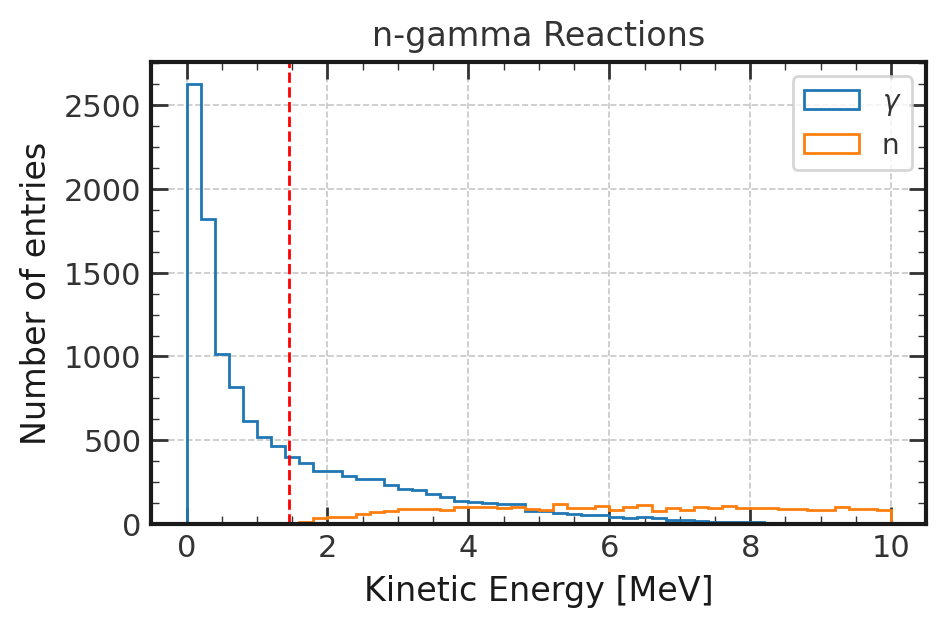

In [190]:
plt.hist(photon_energies,bins=50,range=(0,10.),histtype='step',label=r'$\gamma$')
plt.hist(neutron_energies,bins=50,range=(0,10.),histtype='step',label='n')
plt.title("n-gamma Reactions")
plt.ylabel('Number of entries')
plt.xlabel('Kinetic Energy [MeV]')
plt.axvline(1.46,0,1,ls="--",lw=1.,color='red')
plt.legend()
plt.show()

In [191]:
parent_energies = np.array(np_dict['parent_energy']).flatten()
proton_energies = np.array(np_dict['proton_energy']).flatten()
print(len(parent_energies))
print(len(proton_energies))

2655
2655


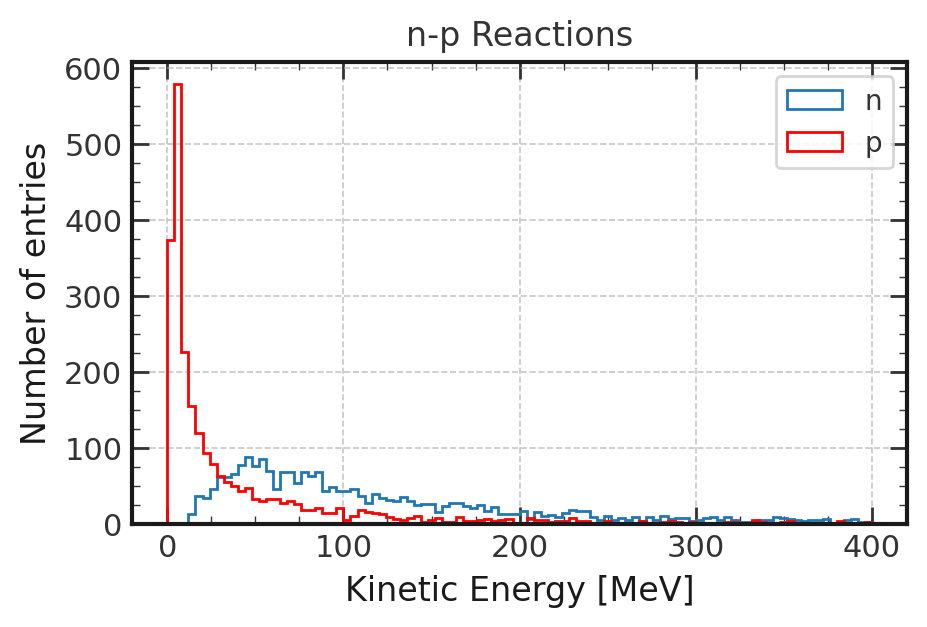

In [192]:
plt.hist(parent_energies,bins=100,range=(0,400.),histtype='step',label='n')
plt.hist(proton_energies,bins=100,range=(0,400.),histtype='step', color='red',label ='p')
plt.title("n-p Reactions")
plt.ylabel('Number of entries')
plt.xlabel('Kinetic Energy [MeV]')
plt.legend()
plt.show()

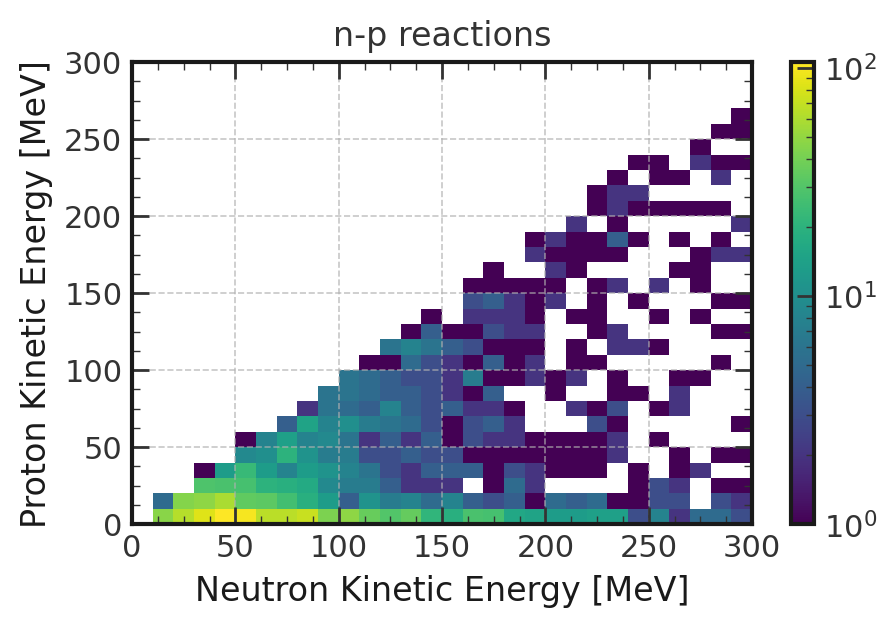

In [193]:
import matplotlib as mpl
plt.hist2d(parent_energies,proton_energies,
           bins=30,range=[[0,300],[0,300]],
           norm=mpl.colors.LogNorm())
plt.colorbar()
plt.title("n-p reactions")
plt.ylabel('Proton Kinetic Energy [MeV]')
plt.xlabel('Neutron Kinetic Energy [MeV]')
plt.show()

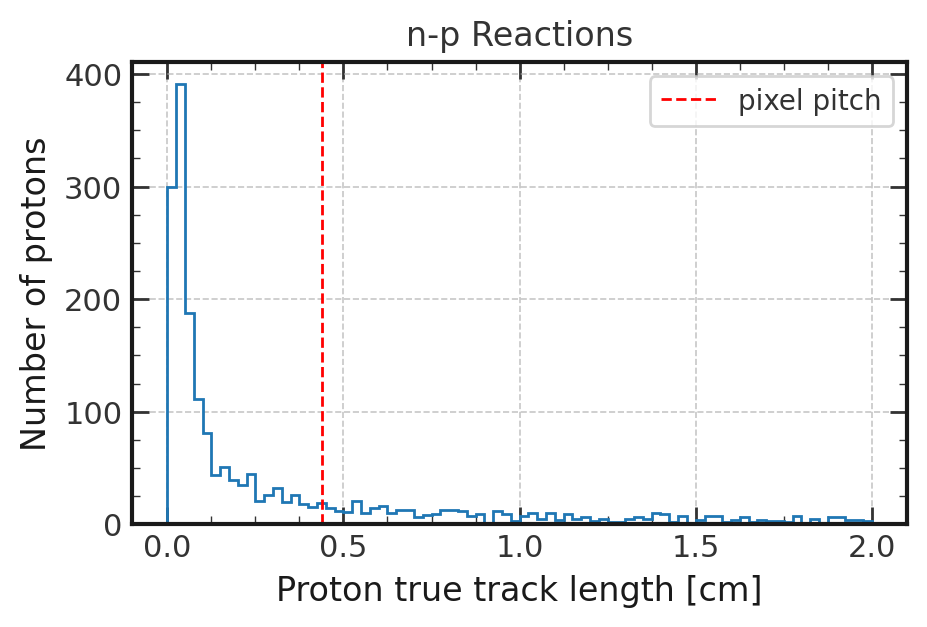

In [194]:
p_lengths = calculate_length(np_dict)
plt.hist(p_lengths,bins=80,histtype='step',range=(0.,2.))
plt.title('n-p Reactions')
plt.xlabel('Proton true track length [cm]')
plt.ylabel('Number of protons')
plt.axvline(0.44,0,1,ls="--",lw=1.,color='red',label='pixel pitch')
plt.legend()
plt.show()

In [195]:
# Add plot of proton multiplicity
# Add plot of nu vtx to proton distance
# Store dictionaries in pkl files 